<a href="https://colab.research.google.com/github/DanaZaretska/dataForNN/blob/master/Model_Siamese_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons==0.8.3

import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import pandas as pd
from glob import glob
import tensorflow_addons as tfa

In [2]:
!git clone -l -s https://github.com/DanaZaretska/dataForNN.git
%cd cloned-repo
!ls

fatal: destination path 'dataForNN' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'cloned-repo'
/content
dataForNN  sample_data


In [3]:
nums = [el for el in range(51)]
nums.pop(41)
nums.pop(29)
nums.pop(22)

22

In [4]:
def get_filenames(root_to_set, num: int):
  dir_path = root_to_set + '/speaker{}'.format(num)
  file_pathes = glob(dir_path + '/*')
  return [num, file_pathes]

def read_image(path):
  img = cv2.imread(path, 0) # read image as grayscale. Set second parameter to 1 if rgb is required
  return img / 255

In [5]:
def make_X_set(root_to_set):
  X = []
  filepathes = []

  for num in nums:
    speaker = []

    filenames = get_filenames(root_to_set, num)[1]
    filepathes.append(filenames)
    
    for path in filenames:
        # speaker.append(read_image(path))
      X.append(read_image(path))
    # X.append(speaker)

  return np.array(X), filepathes

In [6]:
x_train, x_train_filepathes = make_X_set("/content/dataForNN/train_data_grayscale")
x_val, x_val_filepathes = make_X_set("/content/dataForNN/val_data_grayscale")
x_test, x_test_filepathes = make_X_set("/content/dataForNN/test_data_grayscale")

In [7]:
len(x_train), len(x_val), len(x_test)

(736, 380, 144)

In [8]:
def make_indices(filepathes):

  indices = []
  start = 0

  for speaker in filepathes:
    arr = [el for el in range(start, start + len(speaker))] 
    indices.append(arr)
    start += len(speaker)
  return indices

In [9]:
x_train_indices = make_indices(x_train_filepathes)
x_val_indices = make_indices(x_val_filepathes)
x_test_indices = make_indices(x_test_filepathes)

In [10]:
len(x_train_indices), len(x_test_indices), len(x_val_indices)

(48, 48, 48)

In [11]:
x_train.shape, len(x_train_indices)

((736, 288, 432), 48)

In [12]:
def make_Y_set(x_indices):
    Y = []
    idx = 0

    for speaker in x_indices:
      for part in speaker:
        Y.append(nums[idx])
      idx += 1

    return np.array(Y)

In [13]:
y_train = make_Y_set(x_train_indices)
y_val = make_Y_set(x_val_indices)
y_test = make_Y_set(x_test_indices)

In [14]:
def make_pairs(x, y, indices):

    num_classes = 49
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idxs_to_choice = indices[nums.index(label1)].copy()
        idx2 = random.choice(idxs_to_choice)
        while idx2 == idx1:
          idx2 = random.choice(idxs_to_choice)

        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.choice(nums)
        while label2 == label1:
            label2 = random.choice(nums)

        idx2 = random.choice(indices[nums.index(label2)])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train, x_train_indices)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val, x_val_indices)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test, x_test_indices)

In [15]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((288, 432, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(3, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(49, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((288, 432, 1))
input_2 = layers.Input((288, 432, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [16]:
batch_size = 16

In [17]:
siamese.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss(),
    metrics=["accuracy"])

siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 288, 432, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 288, 432, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 49)           6145107     ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [18]:
x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]  
x_test_2 = pairs_test[:, 1]

In [19]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=15
)

Epoch 1/15
92/92 [==============================] - 28s 121ms/step - loss: 0.9772 - accuracy: 0.8383 - val_loss: 0.9931 - val_accuracy: 0.5816
Epoch 2/15
92/92 [==============================] - 10s 109ms/step - loss: 0.9371 - accuracy: 0.9314 - val_loss: 0.9945 - val_accuracy: 0.5000
Epoch 3/15
92/92 [==============================] - 9s 96ms/step - loss: 0.8782 - accuracy: 0.9490 - val_loss: 0.8395 - val_accuracy: 0.9382
Epoch 4/15
92/92 [==============================] - 9s 96ms/step - loss: 0.8240 - accuracy: 0.9579 - val_loss: 0.8073 - val_accuracy: 0.9303
Epoch 5/15
92/92 [==============================] - 9s 96ms/step - loss: 0.7267 - accuracy: 0.9742 - val_loss: 0.6676 - val_accuracy: 0.9697
Epoch 6/15
92/92 [==============================] - 9s 96ms/step - loss: 0.6266 - accuracy: 0.9844 - val_loss: 0.7553 - val_accuracy: 0.9158
Epoch 7/15
92/92 [==============================] - 9s 95ms/step - loss: 0.5306 - accuracy: 0.9878 - val_loss: 0.6942 - val_accuracy: 0.9316
Epoch 8/1

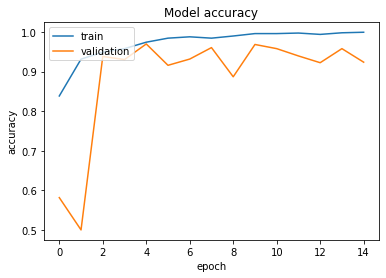

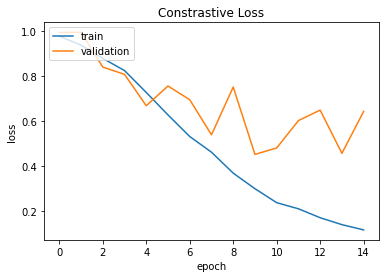

In [20]:
def plt_metric(history, metric, title, has_valid=True):

    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [21]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

9/9 [==============================] - 1s 52ms/step - loss: 0.6653 - accuracy: 0.9271
test loss, test acc: [0.665328860282898, 0.9270833134651184]


In [22]:
results

[0.665328860282898, 0.9270833134651184]

In [23]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(10, 10))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

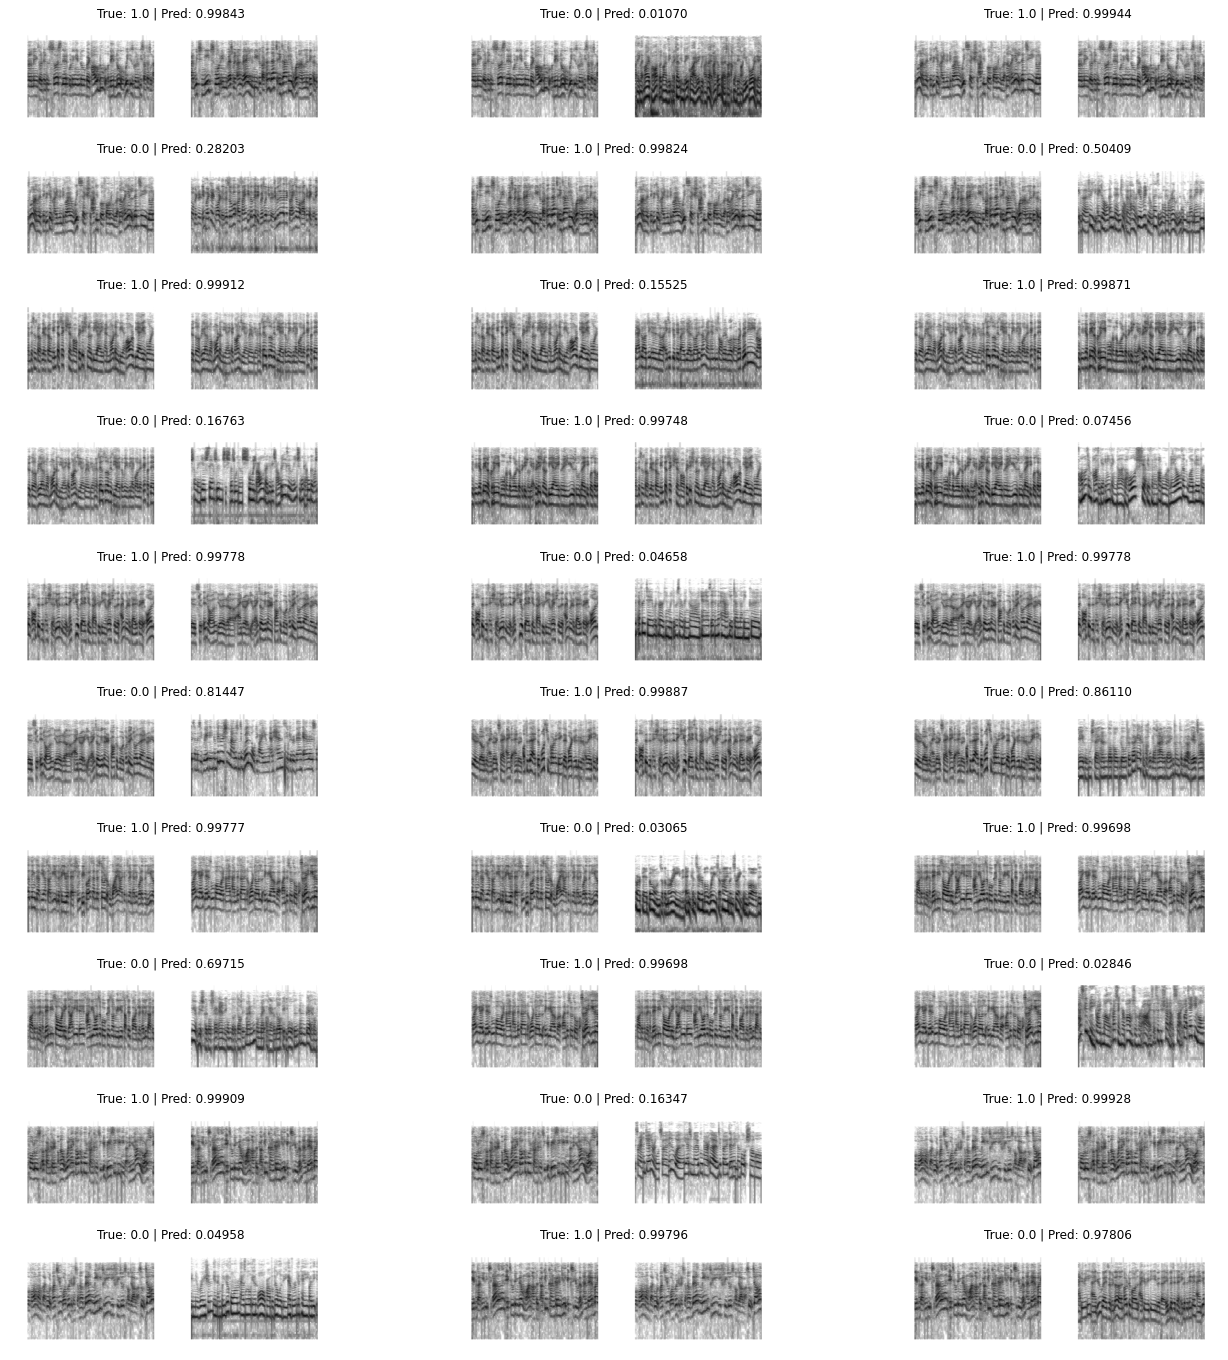

In [24]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=30, predictions=predictions, test=True)